In [1]:
import os
from time import time
from scipy import stats
import pandas as pd
from pandas import DataFrame
import numpy as np
  
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
%matplotlib inline

In [2]:
os.chdir(os.getcwd()+'/HW3-data')

In [3]:
meta = pd.read_csv('ecs171.dataset.txt', sep = "\s+", header= 0)

In [4]:
meta.head()

ID  Strain Medium Stress GenePerturbed  GrowthRate     b3356     b2922  \
0  T8129  MG1655  MD001   none       oxyR_KO       0.637  0.304790  0.506615   
1  T8130  MG1655  MD001   none       oxyR_KO       0.637  0.361095  0.582885   
2  T8131  MG1655  MD001   none       oxyR_KO       0.637  0.295920  0.477482   
3  T8135  MG1655  MD001   none       soxS_KO       0.724  0.332041  0.554672   
4  T8136  MG1655  MD001   none       soxS_KO       0.724  0.323373  0.442617   

      b2519     b3823  ...    b4673  b4684  b4689  b4685  b4683  b4682  b4699  \
0  0.289473  0.289473  ...        0      0      0      0      0      0      0   
1  0.259295  0.259295  ...        0      0      0      0      0      0      0   
2  0.304459  0.304459  ...        0      0      0      0      0      0      0   
3  0.308533  0.308533  ...        0      0      0      0      0      0      0   
4  0.318442  0.318442  ...        0      0      0      0      0      0      0   

   b4698  b4704  b4703  
0      0      0      0  
1      0      0      0  
2      0      0      0  
3      0      0      0  
4      0      0      0  

[5 rows x 4501 columns]

In [5]:
meta.groupby(['Strain']).size()

Strain
BW25113       1
CG2           6
DH5alpha      2
MG1655      141
P2            3
P4X           6
W3110        27
rpoA14        3
rpoA27        2
rpoD3         3
dtype: int64

In [6]:
## 1. Lasso Regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso,LassoCV

## Lasso
meta_X = meta.iloc[:,6:]
meta_y = meta.loc[:,'GrowthRate']

X = meta_X.values
y = meta_y.values
lcv = LassoCV(cv=10, normalize=True, max_iter=10000, verbose = 0)
lcv.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=0)

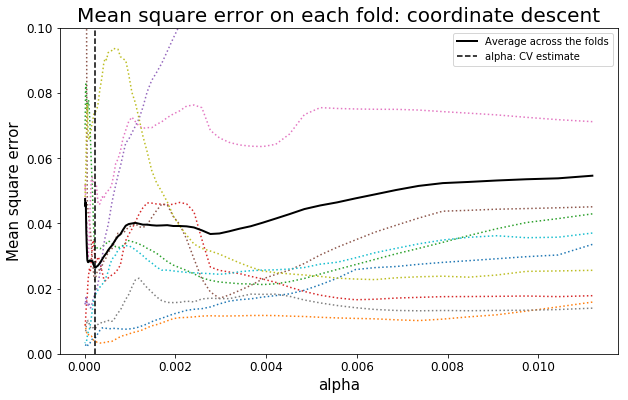

In [7]:
# Display results

plt.figure(figsize=(10,6))
plt.plot(lcv.alphas_, lcv.mse_path_, ':')
plt.plot(lcv.alphas_, lcv.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(lcv.alpha_, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()
plt.xlabel('alpha',fontsize=15)
plt.ylabel('Mean square error',fontsize=15)
plt.title('Mean square error on each fold: coordinate descent', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis('tight')
plt.ylim(0,0.1)
plt.savefig('lambda_choose.png', format='png', dpi=1000)

In [8]:
lcv.alpha_

0.00024105362882507035

In [9]:
sum(lcv.coef_!=0)

95

In [10]:
min(lcv.mse_path_.mean(axis = 1))

0.02638531432507729

In [11]:
# 2. Bootstrap Functionality
## website: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/

from sklearn.utils import resample
from sklearn.metrics import accuracy_score

n_size = int(meta.shape[0])
meta_growth = meta.iloc[:,5:]
def pred_bootstrap(data,X_new,n_iterations):
    boots_y = []
    for i in range(n_iterations):
        # prepare train and test sets
        boots_data = resample(meta_growth.values, n_samples=n_size)
        # fit model using the optimal alpha from Q1
        lasso_mdl = Lasso(alpha=[lcv.alpha_], normalize=True)
        lasso_mdl.fit(boots_data[:,1:], boots_data[:,0])

        # predict the new data
        y_pred = lasso_mdl.predict(X_new)
        boots_y.append(y_pred)
        
    # confidence intervals
    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(boots_y, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(boots_y, p))
    print('%.1f%% confidence interval %.5f and %.5f' % (alpha*100, lower, upper))
    
    return([lower,upper])

In [14]:
## 3. prediction
meta_X_mean = np.mean(meta_X.values,axis=0)
meta_X_mean = np.array([meta_X_mean])
pred_CI = pred_bootstrap(meta_growth,meta_X_mean,1000)

95.0% confidence interval 0.38845 and 0.41660


In [15]:
## 4. SVM classifiers for 4 categories
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler

def RFE_cv(df,X,y_index,name):
    # X,y
    y = df.iloc[:,y_index]
    # X standardization
    sc = StandardScaler()
    X = sc.fit_transform(X)
    # y value transform
    le = LabelEncoder()
    y = le.fit_transform(y)
    y_match = {i:j for i,j in zip(range(len(list(le.classes_))), list(le.classes_))}
    
    # Create the RFE object and compute a cross-validated score.
    svc = SVC(kernel="linear")
    # The "accuracy" scoring is proportional to the number of correct
    # classifications
    rfecv = RFECV(estimator=svc, step=10, cv = StratifiedKFold(3),#cv=KFold(3,shuffle=True,random_state=1),
                  scoring='accuracy')
    
    rfecv.fit(X, y)
    selected = rfecv.support_
    print('done')

    print("Optimal number of features : %d" % rfecv.n_features_)

    # Plot number of features VS. cross-validation scores
    # image names
    plt.figure(figsize = (10,8))
    plt.xlabel("Number of features selected",fontsize=15)
    plt.ylabel("Cross validation score (nb of correct classifications)",fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.savefig(name, format='png', dpi=1000)
    plt.show()
    
    return(selected, y_match)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


done
Optimal number of features : 35


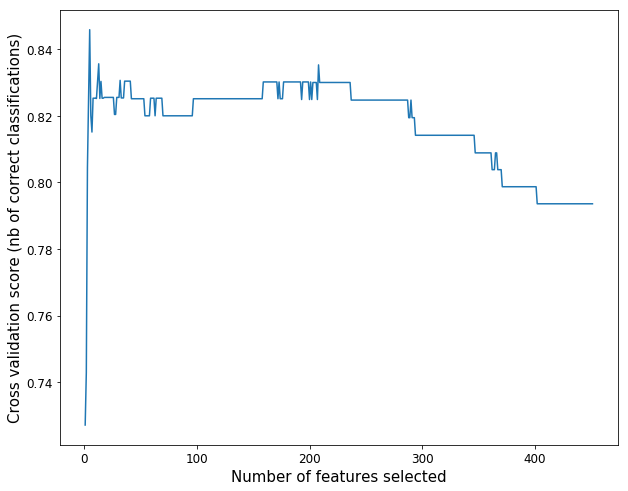

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


done
Optimal number of features : 335


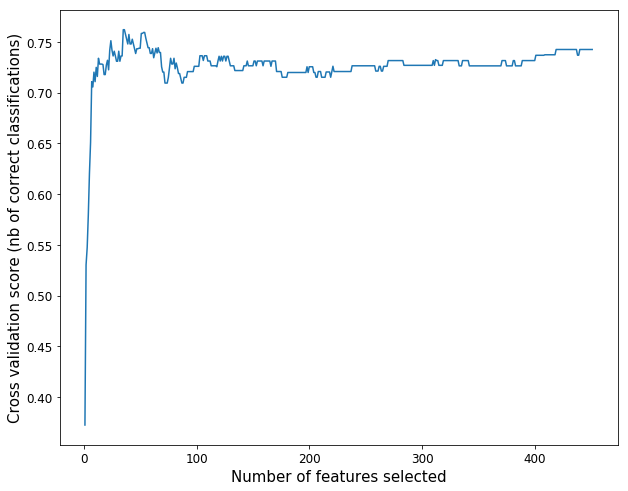

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


done
Optimal number of features : 165


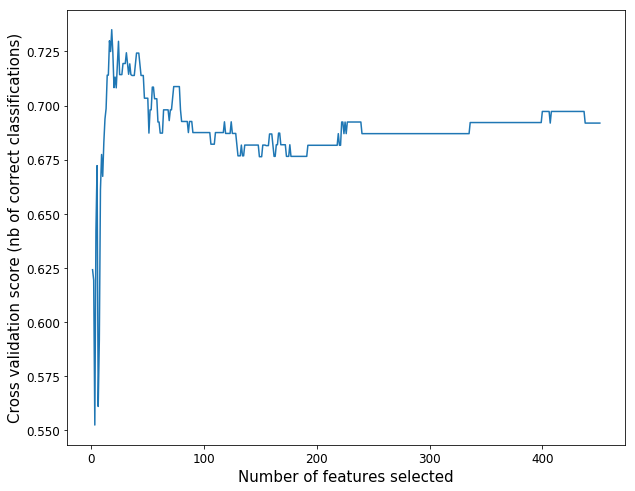

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


done
Optimal number of features : 95


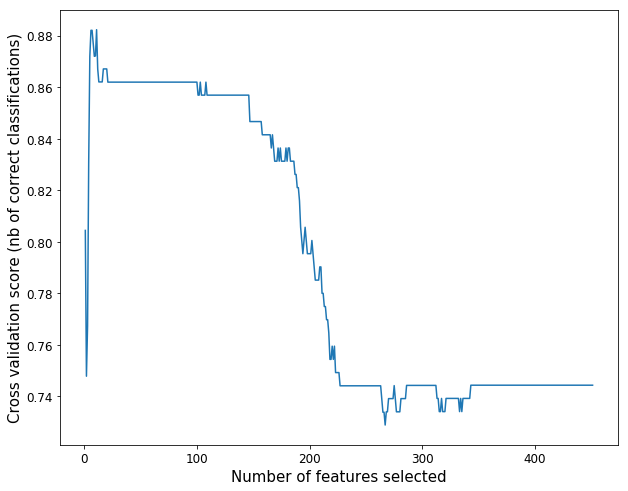

In [16]:
X=meta.iloc[:,6:]
y_list = [1,2,3,4]
overall_select = {}
overall_match = {}
names = ['Strain.png', 'Medium.png', 'Stress.png', 'GenePerturbed.png']
#plt.subplots(4,figsize=(6,24))
for i in y_list:
    selected, y_match = RFE_cv(meta,X,i,names[i-1])
    overall_select.update({meta.columns[i]:selected})
    overall_match.update({meta.columns[i]:y_match})

In [17]:
overall_select

{'Strain': array([False, False, False, ..., False, False, False]),
 'Medium': array([False, False, False, ..., False, False, False]),
 'Stress': array([False, False, False, ..., False, False, False]),
 'GenePerturbed': array([False, False,  True, ..., False, False, False])}

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from itertools import cycle
from statistics import mean

# ROC Curve
def multifold_ROC(y_te,y_score,ttl_class,order,clr):
    #Compute ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    #Binarize the classification
    y_test_bin = label_binarize(y_te, classes=[i for i in ttl_class])
    #Calculate 'micro'-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plot the line
    plt.plot(fpr["micro"], tpr["micro"], alpha = 0.5,
             label='micro-average ROC curve of {0} fold (area = {1:0.4f})'
             ''.format(order, roc_auc["micro"]),
             color=clr, linewidth=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    
    return(fpr["micro"], tpr["micro"],roc_auc["micro"])
    
    
# PR Curve
def multifold_PR(y_te,y_score,ttl_class,order,clr):
    #Compute PR curve and PR area
    precision = dict()
    recall = dict()
    average_precision = dict()
    #Binarize the classification
    y_test_bin = label_binarize(y_te, classes=[i for i in ttl_class])
    #Calculate 'micro'-average
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(),
                                                                    y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_score,
                                                         average="micro")
    
    # plot the lines
    plt.plot(recall["micro"], precision["micro"], alpha = 0.5,
             label='micro-average Precision-recall for {0} (area = {1:0.4f})'
                  ''.format(order, average_precision["micro"]),
             color=clr, linewidth=2)
                  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Recall',fontsize=20)
    plt.ylabel('Precision',fontsize=20)
    
    return(y_test_bin,average_precision["micro"])

In [29]:
# functions for 10-FOLD Cross-Validation
def svm_cv(name,curve_type,split):
    # split by 10 parts while I assigned split = 10
    # skf = StratifiedKFold(n_splits=split,random_state=1,shuffle=True)
    skf = KFold(n_splits=split,random_state=1,shuffle=True)
    model = SVC(kernel="linear")

    plt.figure(figsize = (15, 12))
    # collect the 10 accuracies
    accu = []
    
    folds = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
    colors = ['black', 'purple', 'blue', 'olive', 'green', 'cyan', 'yellow', 'orange', 'magenta', 'red']
    i = 0 # count the fold
    # get the correponding X and y for each category
    X = meta_X.loc[:,list(overall_select.get(name))]
    y = meta.loc[:,name]
    
    # for ROC 
    Y_axis = []
    mean_ = np.linspace(0, 1, 100)
    area = []
    # for PR
    Y_test_bin = []
    Y_score = []
    for train_index, test_index in skf.split(X, y):
        X_tr_cv, X_te_cv = X.iloc[train_index,:], X.iloc[test_index,:]
        y_tr_cv, y_te_cv = y[train_index], y[test_index]
        
        ttl_class = list(set(y_tr_cv))
        model.fit(X_tr_cv, y_tr_cv)
        y_score_cv = model.decision_function(X_te_cv)
        if curve_type == "ROC":
            x_axis, y_axis, area_ = multifold_ROC(y_te_cv,y_score_cv,ttl_class,folds[i],colors[i])
            Y_axis.append(interp(mean_, x_axis, y_axis))
        elif curve_type == 'PR':
            y_test_bin, area_ = multifold_PR(y_te_cv,y_score_cv,ttl_class,folds[i],colors[i])
            Y_test_bin.extend(y_test_bin.ravel())
            Y_score.extend(y_score_cv.ravel())
        else:
            sys.exit(0)
        i += 1
        
        area.append(area_)
        accu.append(model.score(X_te_cv, y_te_cv))
    
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    # Plot the mean curve
    mean_y_axis = np.mean(Y_axis,axis = 0)
    mean_area = mean(area)
    print('mean AU'+curve_type+": "+str(mean_area))
    std_area = np.std(area)
    if curve_type == 'ROC':
        plt.plot(mean_,mean_y_axis,color='orchid',
                 label='Mean micro-average {0} Curve (AUC = {1:0.4f} with SD {2:0.4f})'
                 ''.format(curve_type, mean_area, std_area),
                 lw=5, ls ='-.')
        plt.title('ROC curve for 10 folds of '+name,fontsize=35)
        plt.legend(loc="lower right", prop=dict(size=12))
    elif curve_type == 'PR':
        mean_precision, mean_recall, _ = precision_recall_curve(Y_test_bin,
                                                                         Y_score)
        plt.plot(mean_recall,mean_precision,color='orchid',
                 label='Mean micro-average {0} Curve (AUC = {1:0.4f} with SD {2:0.4f})'
                 ''.format(curve_type, mean_area, std_area),
                 lw=3, ls ='-.')
        plt.title('PR curve for 10 folds of '+name,fontsize=35)
        plt.legend(loc="lower left", prop=dict(size=12))

    # get the mean accuracy
    png_name = name+'_'+curve_type+'.png'
    plt.savefig(png_name, format='png', dpi=1000)
    #plt.show()
    mean_accu = mean(accu)
    print('mean accuracy:',mean_accu)
    
    
    return(mean_accu, mean_area)

Strain
mean AUROC: 0.8176335317855469
mean accuracy: 0.9431578947368421
Medium
mean AUROC: 0.5822103085349606
mean accuracy: 0.9163157894736842
Stress
mean AUROC: 0.1669005078485688
mean accuracy: 0.9076315789473685
GenePerturbed
mean AUROC: 0.2013727753335868
mean accuracy: 0.9486842105263158


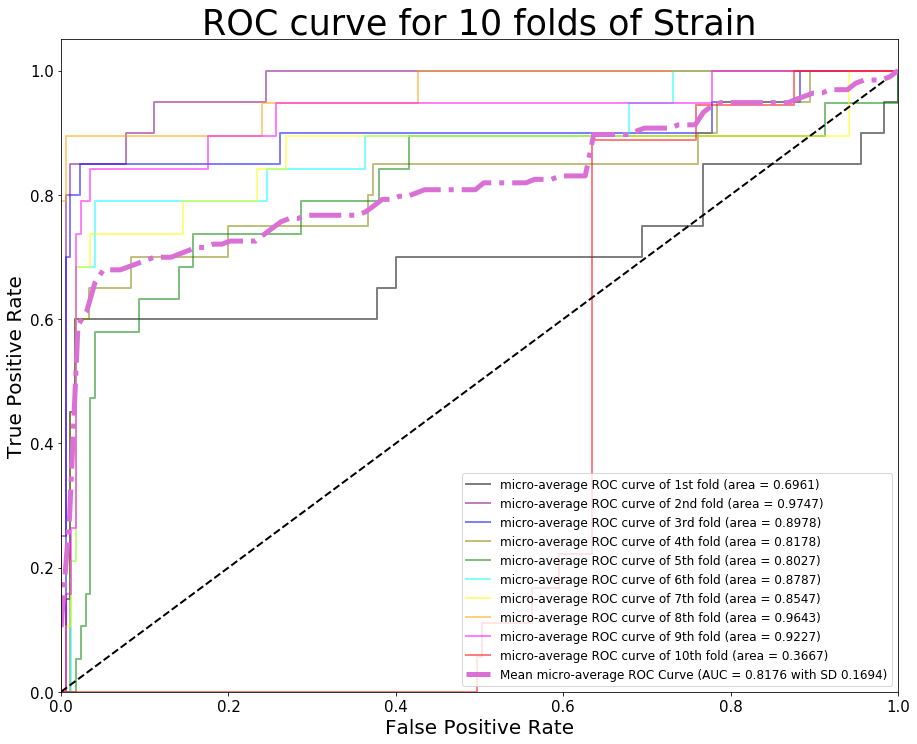

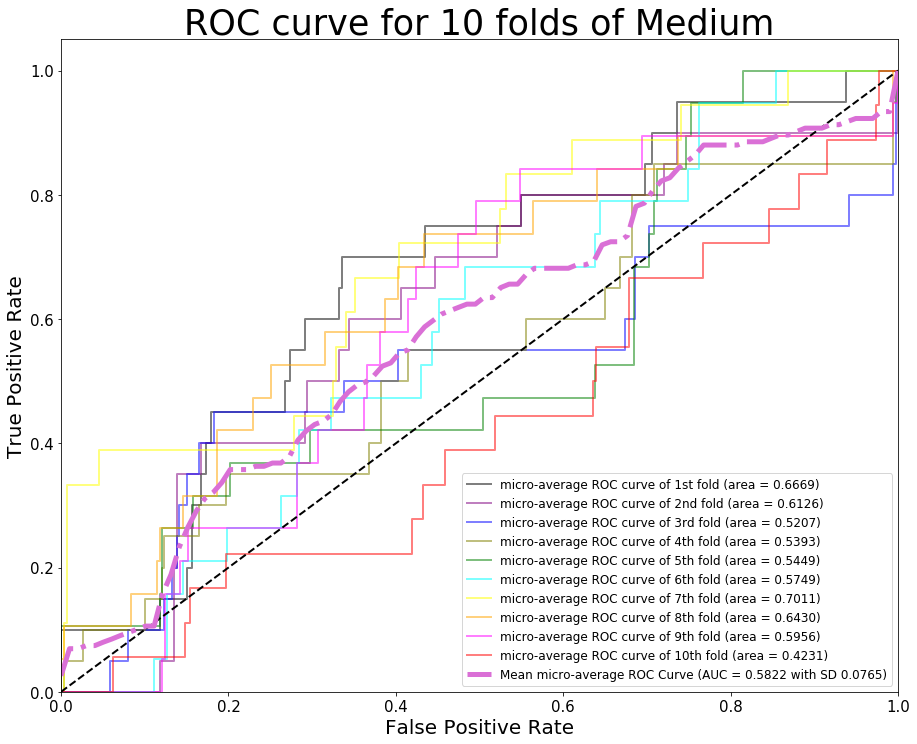

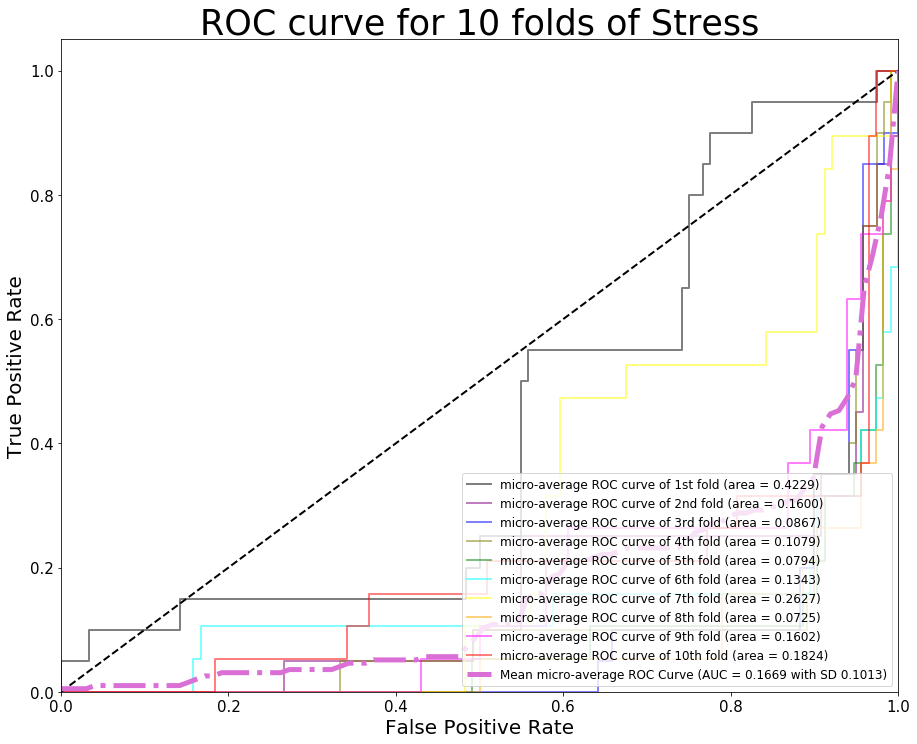

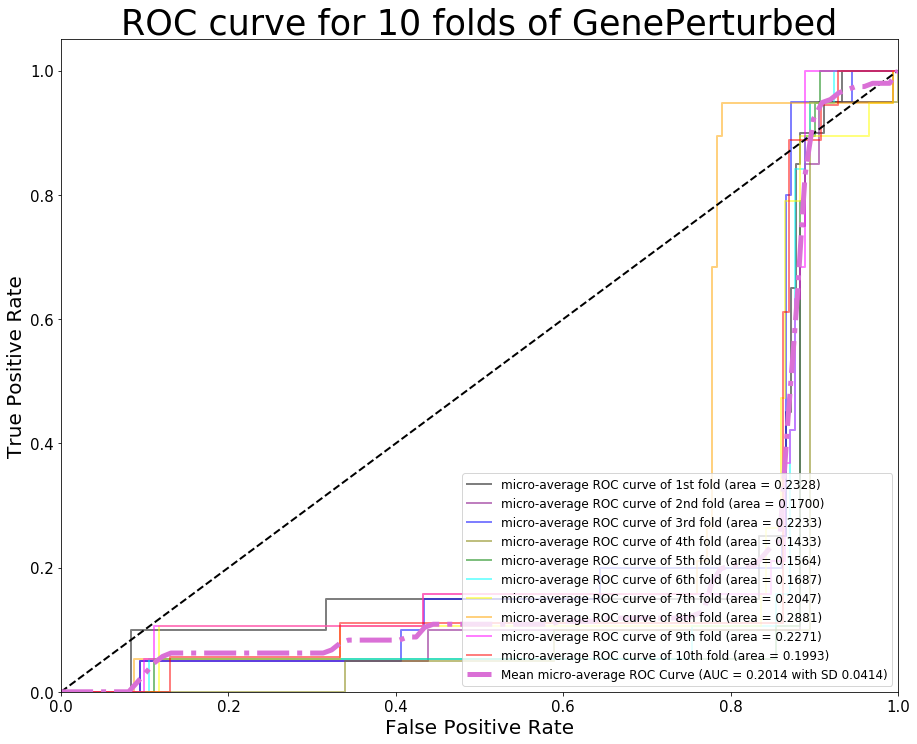

In [20]:
# ROC Curves for all 4 categories
for name in names:
    name = name.split(".")[0]
    print(name)
    svm_cv(name,'ROC',10)

Strain
mean AUPR: 0.5823570471431785


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean accuracy: 0.9431578947368421
Medium


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean AUPR: 0.1246974208235119
mean accuracy: 0.9163157894736842
Stress
mean AUPR: 0.09576572777352332


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean accuracy: 0.9076315789473685
GenePerturbed
mean AUPR: 0.06647942521628504


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean accuracy: 0.9486842105263158


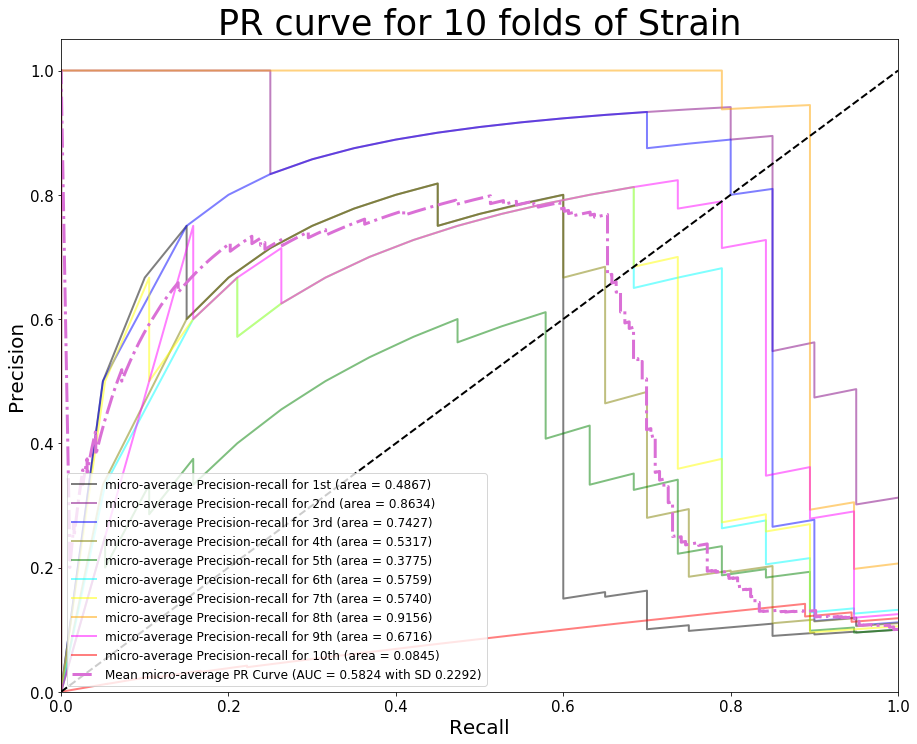

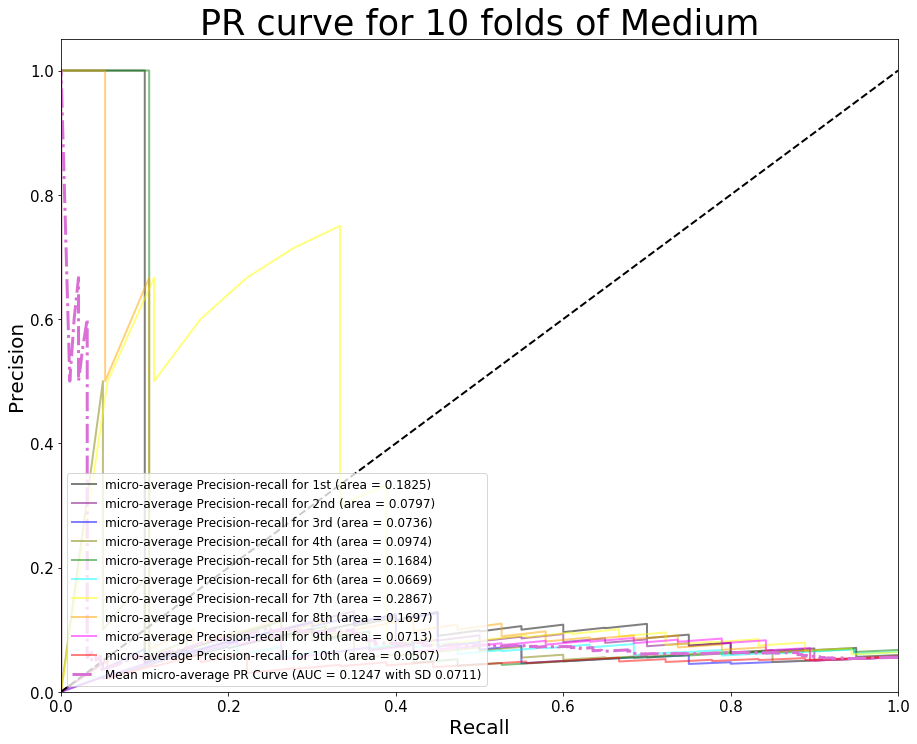

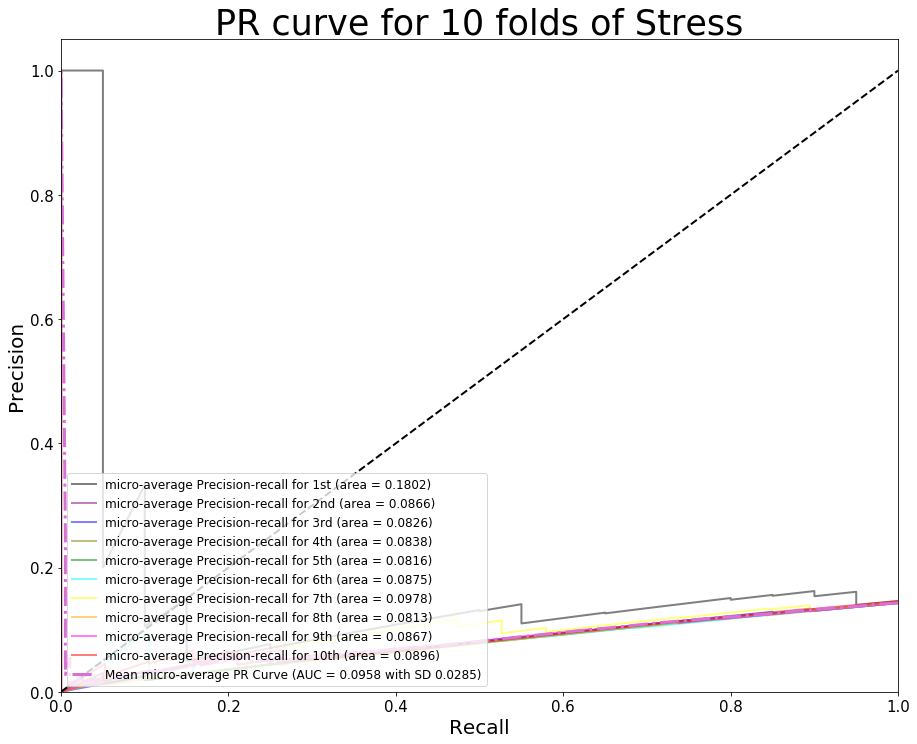

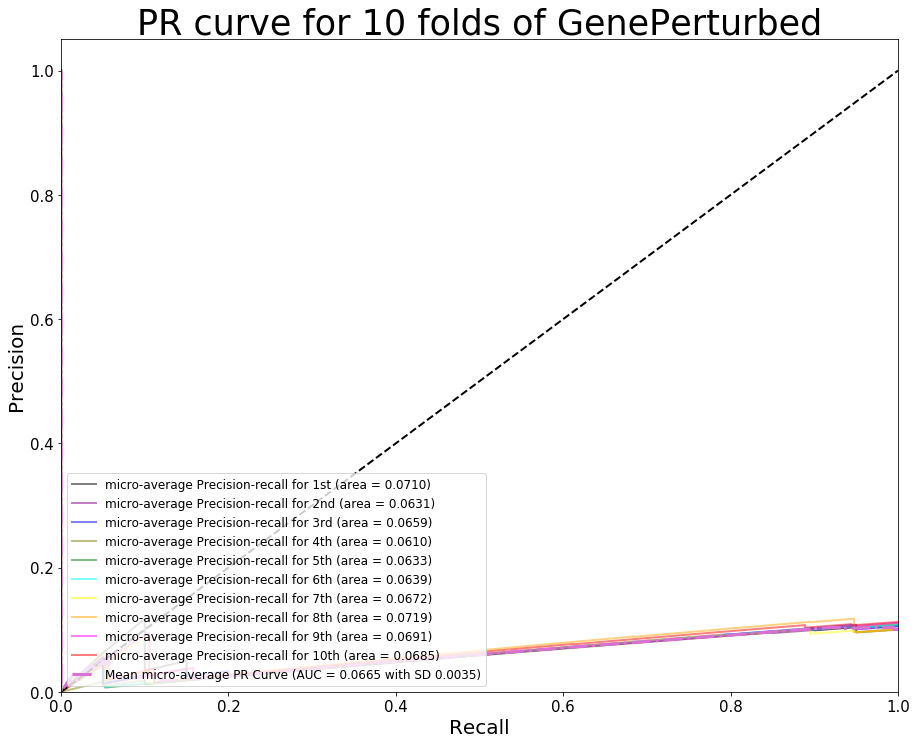

In [30]:
# PR Curves for all 4 categories
for name in names:
    name = name.split(".")[0]
    print(name)
    svm_cv(name,'PR',10)

### 5. One composite SVM classifier

In [73]:
## 5.
meta['MediumStress'] = meta['Medium']+','+meta['Stress']

def svm_cv_2(X,y,name,curve_type,split):
    # split by 10 parts while I assigned split = 10
    # skf = StratifiedKFold(n_splits=split,random_state=1,shuffle=True)
    skf = KFold(n_splits=split,random_state=1,shuffle=True)
    model = SVC(kernel="linear")

    plt.figure(figsize = (15, 12))
    # collect the 10 accuracies
    accu = []
    
    folds = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
    colors = ['black', 'purple', 'blue', 'olive', 'green', 'cyan', 'yellow', 'orange', 'magenta', 'red']
    i = 0 # count the fold
    
    # for ROC 
    Y_axis = []
    mean_ = np.linspace(0, 1, 100)
    area = []
    # for PR
    Y_test_bin = []
    Y_score = []
    for train_index, test_index in skf.split(X, y):
        X_tr_cv, X_te_cv = X.iloc[train_index,:], X.iloc[test_index,:]
        y_tr_cv, y_te_cv = y[train_index], y[test_index]
        
        ttl_class = list(set(y_tr_cv))
        model.fit(X_tr_cv, y_tr_cv)
        y_score_cv = model.decision_function(X_te_cv)
        if curve_type == "ROC":
            x_axis, y_axis, area_ = multifold_ROC(y_te_cv,y_score_cv,ttl_class,folds[i],colors[i])
            Y_axis.append(interp(mean_, x_axis, y_axis))
        elif curve_type == 'PR':
            y_test_bin, area_ = multifold_PR(y_te_cv,y_score_cv,ttl_class,folds[i],colors[i])
            Y_test_bin.extend(y_test_bin.ravel())
            Y_score.extend(y_score_cv.ravel())
        else:
            sys.exit(0)
        i += 1
        
        area.append(area_)
        accu.append(model.score(X_te_cv, y_te_cv))
    
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    # Plot the mean curve
    mean_y_axis = np.mean(Y_axis,axis = 0)
    mean_area = mean(area)
    print('mean AU'+curve_type+": "+str(mean_area))
    std_area = np.std(area)
    if curve_type == 'ROC':
        plt.plot(mean_,mean_y_axis,color='orchid',
                 label='Mean micro-average {0} Curve (AUC = {1:0.4f} with SD {2:0.4f})'
                 ''.format(curve_type, mean_area, std_area),
                 lw=5, ls ='-.')
        plt.title('ROC curve for 10 folds of '+name.split('_')[0],fontsize=35)
        plt.legend(loc="lower right", prop=dict(size=12))
    elif curve_type == 'PR':
        mean_precision, mean_recall, _ = precision_recall_curve(Y_test_bin,
                                                                         Y_score)
        plt.plot(mean_recall,mean_precision,color='orchid',
                 label='Mean micro-average {0} Curve (AUC = {1:0.4f} with SD {2:0.4f})'
                 ''.format(curve_type, mean_area, std_area),
                 lw=3, ls ='-.')
        plt.title('PR curve for 10 folds of '+name.split('_')[0],fontsize=35)
        plt.legend(loc="lower left", prop=dict(size=12))

    # get the mean accuracy
    png_name = name+'_'+curve_type+'.png'
    plt.savefig(png_name, format='png', dpi=1000)
    mean_accu = mean(accu)
    print('mean accuracy:',mean_accu)
    
    
    return(mean_accu, mean_area)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


done
Optimal number of features : 195


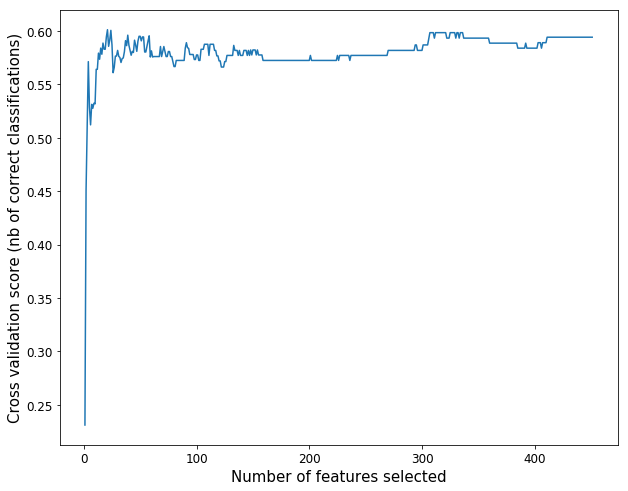

In [32]:
## feature selection
X_new=meta.iloc[:,6:-1]
selected, y_match = RFE_cv(meta,X_new,-1,'MediumStress.png')

mean AUROC: 0.5502742767005232
mean accuracy: 0.8389473684210527


(0.8389473684210527, 0.5502742767005232)

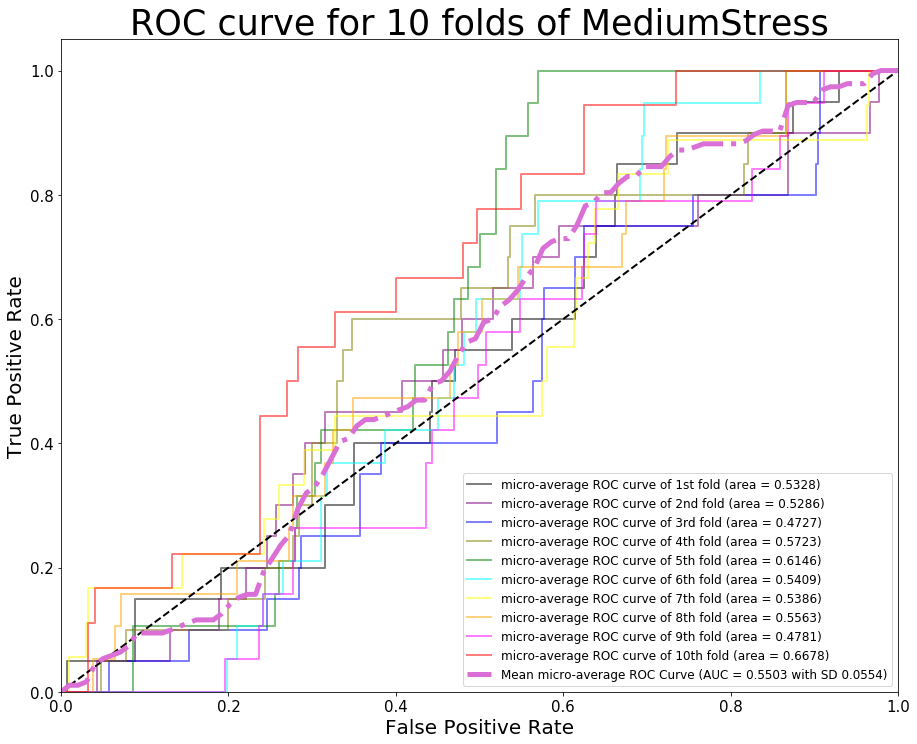

In [74]:
X_selected = X_new.iloc[:,selected]
# ROC Curve
svm_cv_2(X_selected,meta['MediumStress'],'MediumStress_ROC.png','ROC',10)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean AUPR: 0.05425045702284659
mean accuracy: 0.8389473684210527


(0.8389473684210527, 0.05425045702284659)

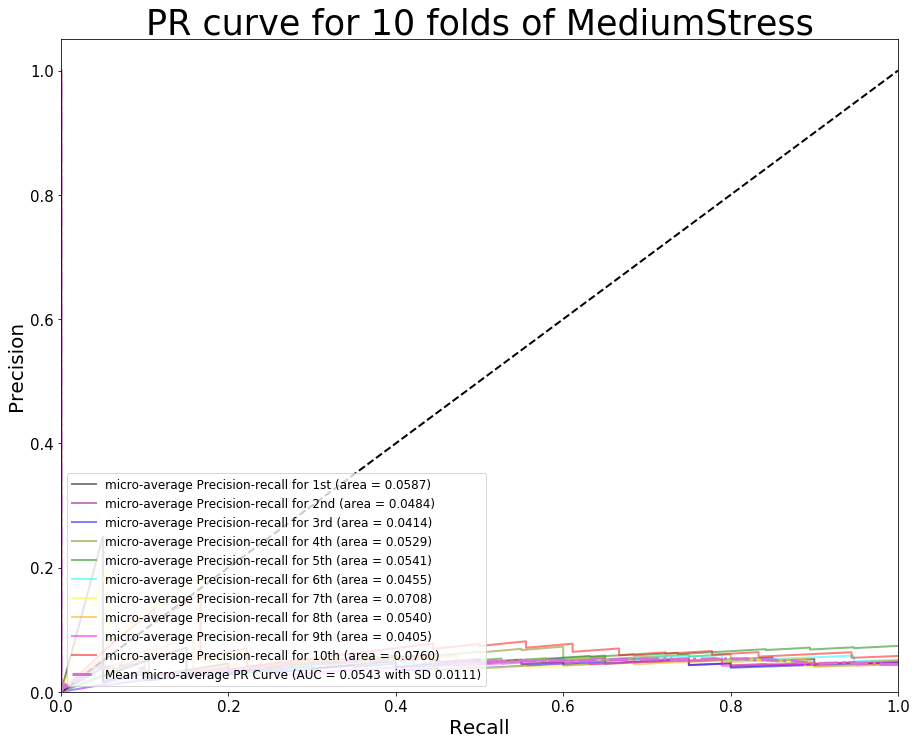

In [75]:
# PR Curve
svm_cv_2(X_selected,meta['MediumStress'],'MediumStress_PR.png','PR',10)

In [76]:
def svm_cv_acc(X,data,split):
    # split by 10 parts while I assigned split = 10
    # skf = StratifiedKFold(n_splits=split,random_state=1,shuffle=True)
    skf = KFold(n_splits=split,random_state=1,shuffle=True)
    model = SVC(kernel="linear")

    # collect the accuracies
    accu_2 = []
    accu_3 = []
    accu = []
    y_compose = data.loc[:,'MediumStress']
    y_2 = data.loc[:,'Medium']
    y_3 = data.loc[:,'Stress']
    for train_index, test_index in skf.split(X, y):
        X_tr_cv, X_te_cv = X.iloc[train_index,:], X.iloc[test_index,:]
        y_tr_cv, y_te_cv = y_compose[train_index], y_compose[test_index]
        # Medium category
        y_test_2 = y_2[test_index]
        # Stress category
        y_test_3 = y_3[test_index]
        
        
        
        model.fit(X_tr_cv, y_tr_cv)
        y_pred = model.predict(X_te_cv)
        y_pred_2 = [i.split(",")[0] for i in y_pred]
        y_pred_3 = [i.split(",")[1] for i in y_pred]
        
        accu_2.append(sum(y_pred_2 == y_test_2)/len(y_test_2))
        accu_3.append(sum(y_pred_3 == y_test_3)/len(y_test_3))
        accu.append((sum(y_pred_2 == y_test_2)+sum(y_pred_3 == y_test_3))/(len(y_test_2)+len(y_test_3)))

    # get the mean accuracy
    mean_accu = mean(accu)
    mean_accu_2 = mean(accu_2)
    mean_accu_3 = mean(accu_3)
    print('Overall mean accuracy:',mean_accu)
    print('mean accuracy of Medium:',mean_accu_2)
    print('mean accuracy of Stress:',mean_accu_3)
    
    return(mean_accu,mean_accu_2,mean_accu_3)

In [77]:
svm_cv_acc(meta_X,meta,10)

Overall mean accuracy: 0.8448684210526316
mean accuracy of Medium: 0.8494736842105263
mean accuracy of Stress: 0.8402631578947368


(0.8448684210526316, 0.8494736842105263, 0.8402631578947368)

### 6. PCA

In [35]:
from sklearn.decomposition import PCA

#Apply the principal components analysis
pca = PCA()
pca.fit(X_new)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [42]:
pca.components_

array([[-1.55403627e-03, -9.32294492e-04, -4.03288956e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.83562775e-06, -3.53463094e-04,  7.05713210e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.35732355e-04, -9.99323416e-04, -3.35026080e-04, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [ 1.04938750e-03,  1.58698921e-02, -6.05454071e-04, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 8.09403809e-03, -9.48835229e-02, -9.00453578e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.22575276e-02, -1.68547978e-01, -1.44829284e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [43]:
X_new.columns.values

array(['b3356', 'b2922', 'b2519', ..., 'b4698', 'b4704', 'b4703'],
      dtype=object)

In [44]:
#Match the labels of components
pc = pca.components_[:3]
pc = pd.DataFrame(pc)
pc.columns = X_new.columns.values

In [45]:
pc.head()

b3356     b2922     b2519     b3823     b3824     b3353     b1500  \
0 -0.001554 -0.000932 -0.000403 -0.001031 -0.000553 -0.000627 -0.004784   
1 -0.000002 -0.000353  0.000706 -0.000696 -0.001039  0.000086 -0.012252   
2 -0.000736 -0.000999 -0.000335  0.000312 -0.000457 -0.000461 -0.012913   

     b2923     b2513     b2512  ...    b4673  b4684  b4689  b4685  b4683  \
0  0.00005 -0.001610 -0.000950  ...      0.0    0.0    0.0    0.0    0.0   
1 -0.00155  0.000024  0.000610  ...      0.0    0.0    0.0    0.0    0.0   
2 -0.00171 -0.001646 -0.000968  ...     -0.0   -0.0   -0.0   -0.0   -0.0   

   b4682  b4699  b4698  b4704  b4703  
0    0.0    0.0    0.0    0.0    0.0  
1    0.0    0.0    0.0    0.0    0.0  
2   -0.0   -0.0   -0.0   -0.0   -0.0  

[3 rows x 4495 columns]

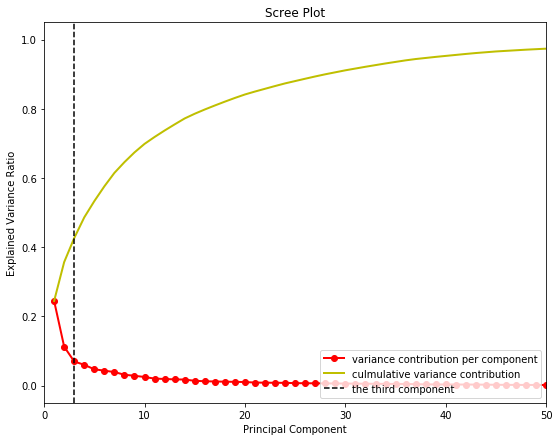

In [47]:
#Draw a scree plot
#Reference: https://stats.stackexchange.com/questions/12819/how-to-draw-a-scree-plot-in-python
fig = plt.figure(figsize=(9,7))
var = pca.explained_variance_ratio_
num = [i+1 for i in range(len(var))]
cml_ratio = [sum(var[:i+1]) for i in range(len(var))]

plt.plot(num, var, 'ro-', linewidth=2, label = 'variance contribution per component')
plt.plot(num, cml_ratio, 'y-', linewidth=2, label = 'culmulative variance contribution')
plt.axvline(x=3,color ='k',ls='--', label='the third component')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xlim(0,50)
plt.legend(loc='lower right')

plt.show()

In [48]:
for i in range(3):
    pc1 = pc.iloc[i]
    print('component {}:\n {}\n'.format(i+1,pc1[abs(pc1)>=0.2]))

component 1:
 b4061    0.790332
b1028    0.307810
b3394    0.406130
b3662    0.220080
Name: 0, dtype: float64

component 2:
 b1743    0.98704
Name: 1, dtype: float64

component 3:
 b4061    0.446100
b3328    0.203332
b1028   -0.469394
b3394   -0.480148
b3662   -0.312225
b4029    0.314231
Name: 2, dtype: float64



In [80]:
def svm_cv_3(X,y,name,curve_type,split):
    # split by 10 parts while I assigned split = 10
    # skf = StratifiedKFold(n_splits=split,random_state=1,shuffle=True)
    skf = KFold(n_splits=split,random_state=1,shuffle=True)
    model = SVC(kernel="linear")

    plt.figure(figsize = (15, 12))
    # collect the 10 accuracies
    accu = []
    
    folds = ['1st','2nd','3rd','4th','5th','6th','7th','8th','9th','10th']
    colors = ['black', 'purple', 'blue', 'olive', 'green', 'cyan', 'yellow', 'orange', 'magenta', 'red']
    i = 0 # count the fold
    
    # for ROC 
    Y_axis = []
    mean_ = np.linspace(0, 1, 100)
    area = []
    # for PR
    Y_test_bin = []
    Y_score = []
    for train_index, test_index in skf.split(X, y):
        X_tr_cv, X_te_cv = X.iloc[train_index,:], X.iloc[test_index,:]
        y_tr_cv, y_te_cv = y[train_index], y[test_index]
        
        ttl_class = list(set(y_tr_cv))
        model.fit(X_tr_cv, y_tr_cv)
        y_score_cv = model.decision_function(X_te_cv)
        if curve_type == "ROC":
            x_axis, y_axis, area_ = multifold_ROC(y_te_cv,y_score_cv,ttl_class,folds[i],colors[i])
            Y_axis.append(interp(mean_, x_axis, y_axis))
        elif curve_type == 'PR':
            y_test_bin, area_ = multifold_PR(y_te_cv,y_score_cv,ttl_class,folds[i],colors[i])
            Y_test_bin.extend(y_test_bin.ravel())
            Y_score.extend(y_score_cv.ravel())
        else:
            sys.exit(0)
        i += 1
        
        area.append(area_)
        accu.append(model.score(X_te_cv, y_te_cv))
    
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    # Plot the mean curve
    mean_y_axis = np.mean(Y_axis,axis = 0)
    mean_area = mean(area)
    print('mean AU'+curve_type+": "+str(mean_area))
    std_area = np.std(area)
    if curve_type == 'ROC':
        plt.plot(mean_,mean_y_axis,color='orchid',
                 label='Mean micro-average {0} Curve (AUC = {1:0.4f} with SD {2:0.4f})'
                 ''.format(curve_type, mean_area, std_area),
                 lw=5, ls ='-.')
        plt.title('ROC curve for 10 folds of '+name.split('_')[2].split('.')[0],fontsize=35)
        plt.legend(loc="lower right", prop=dict(size=12))
    elif curve_type == 'PR':
        mean_precision, mean_recall, _ = precision_recall_curve(Y_test_bin,
                                                                         Y_score)
        plt.plot(mean_recall,mean_precision,color='orchid',
                 label='Mean micro-average {0} Curve (AUC = {1:0.4f} with SD {2:0.4f})'
                 ''.format(curve_type, mean_area, std_area),
                 lw=3, ls ='-.')
        plt.title('PR curve for 10 folds of '+name.split('_')[2].split('.')[0],fontsize=35)
        plt.legend(loc="lower left", prop=dict(size=12))

    # get the mean accuracy
    png_name = name+'_'+curve_type+'.png'
    plt.savefig(png_name, format='png', dpi=1000)
    mean_accu = mean(accu)
    print('mean accuracy:',mean_accu)
    
    
    return(mean_accu, mean_area)

# get the 3 PCA features

mean AUROC: 0.8075805235195546
mean accuracy: 0.7115789473684211
mean AUROC: 0.5400780976150811
mean accuracy: 0.5815789473684211
mean AUROC: 0.391504270544783
mean accuracy: 0.7113157894736842
mean AUROC: 0.39777711543219935
mean accuracy: 0.8039473684210526


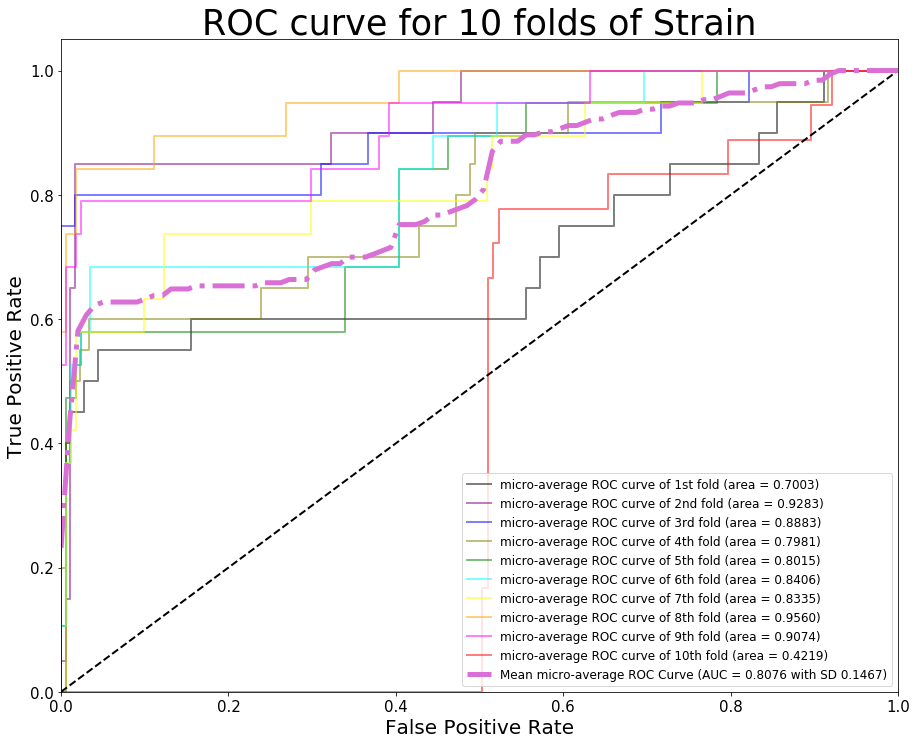

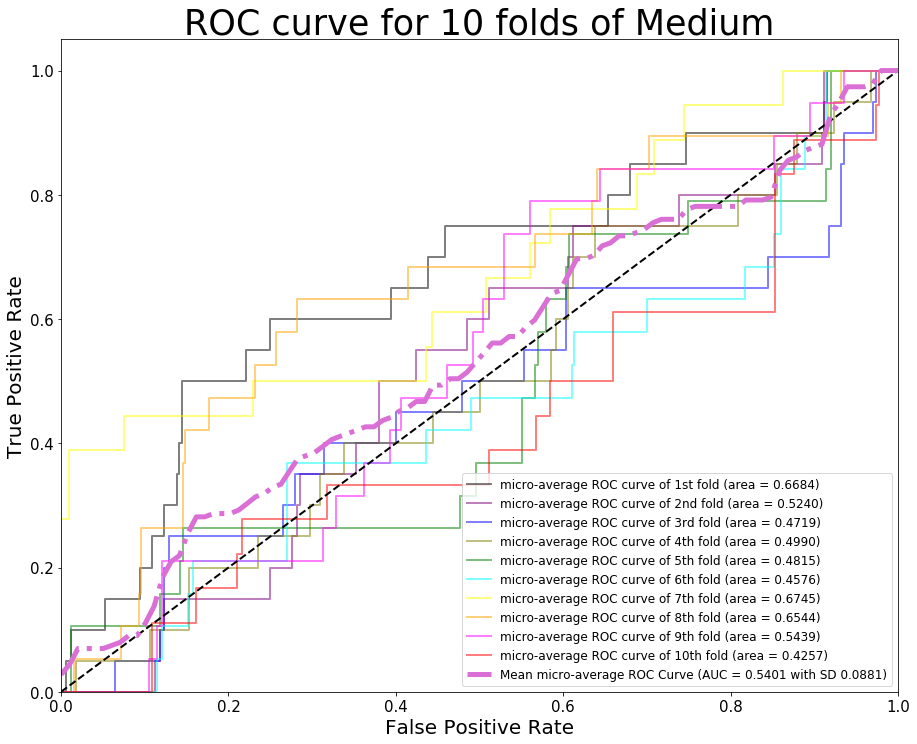

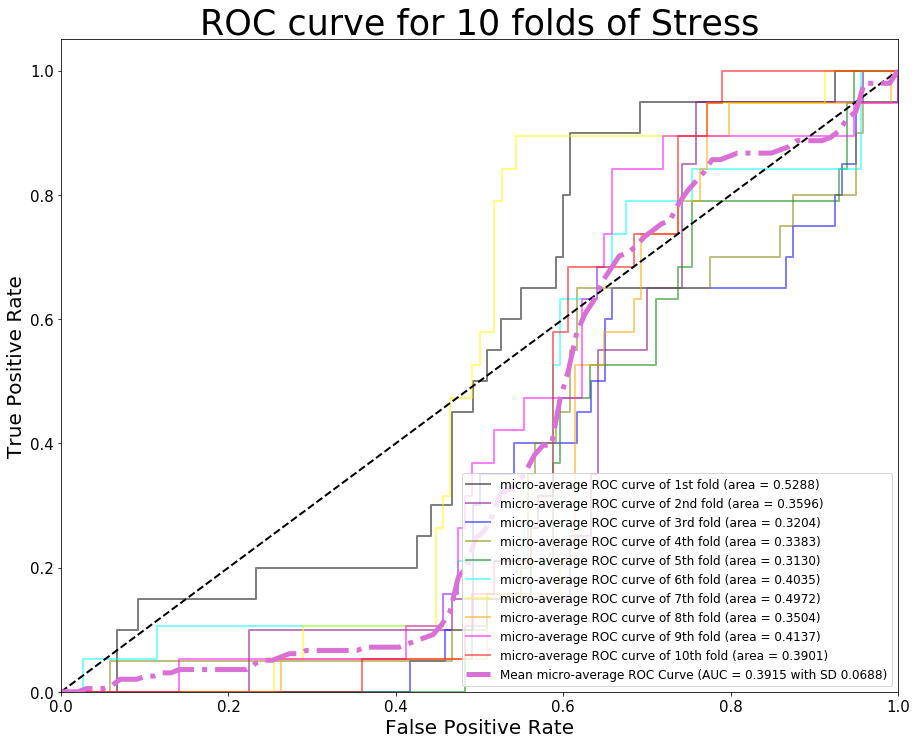

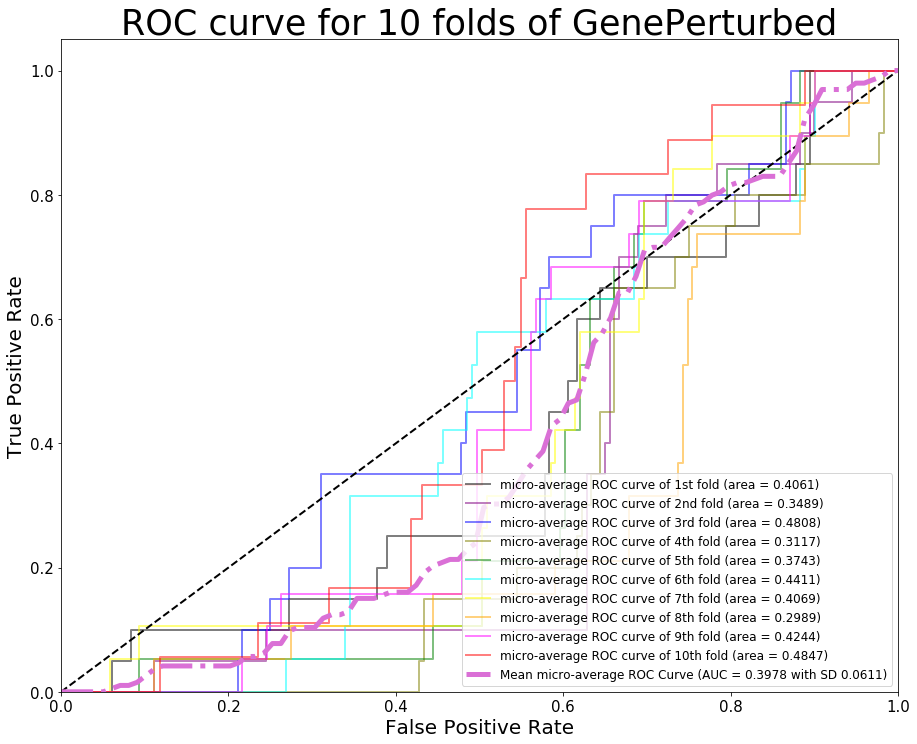

In [84]:
pca = PCA(n_components=3)
X_pca = pd.DataFrame(pca.fit_transform(X_new),columns=['1pc','2pc','3pc'])
for i in [1,2,3,4]:
    y = meta.iloc[:,i]
    name = 'PCA_ROC_'+meta.columns[i]+'.png'
    svm_cv_3(X_pca,y,name,'ROC',10)

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean AUPR: 0.6047340340390863
mean accuracy: 0.7115789473684211
mean AUPR: 0.10733054504268387


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean accuracy: 0.5815789473684211
mean AUPR: 0.11971732624980438


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean accuracy: 0.7113157894736842


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


mean AUPR: 0.08367022206075778
mean accuracy: 0.8039473684210526


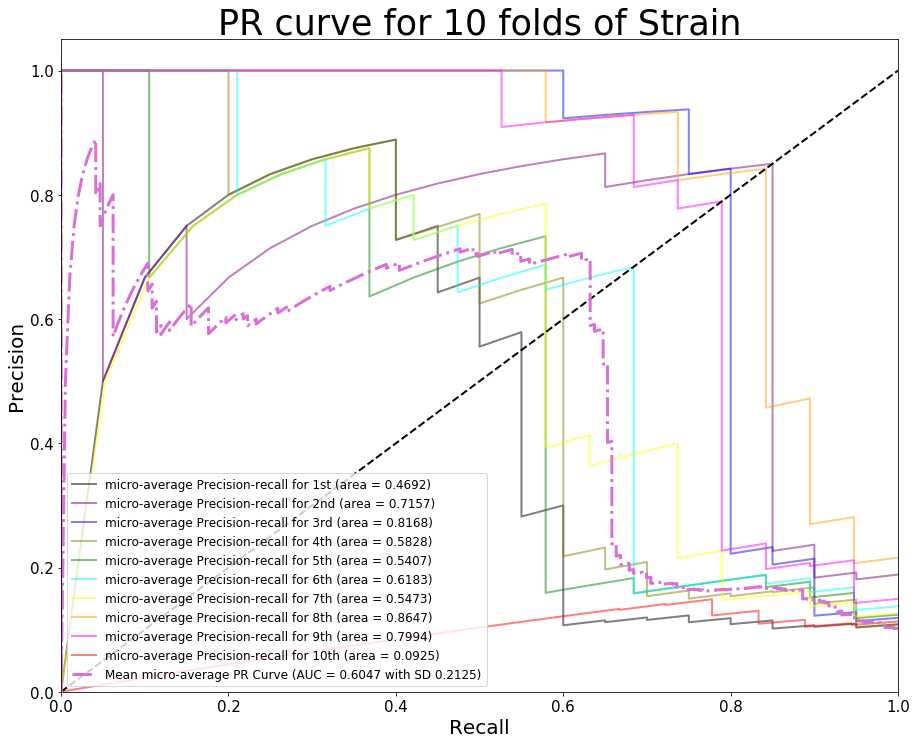

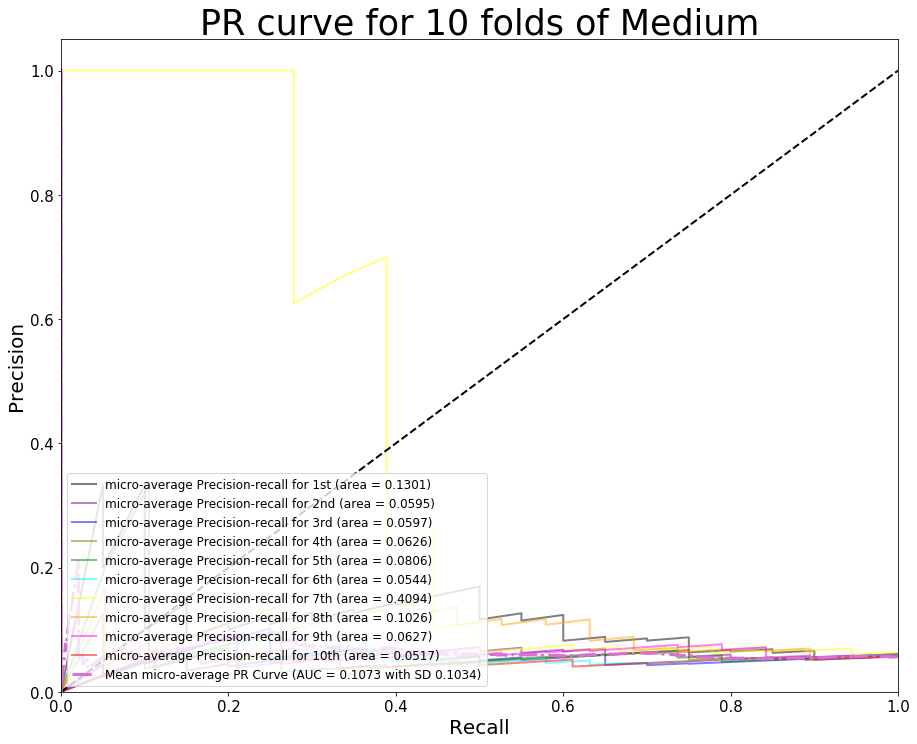

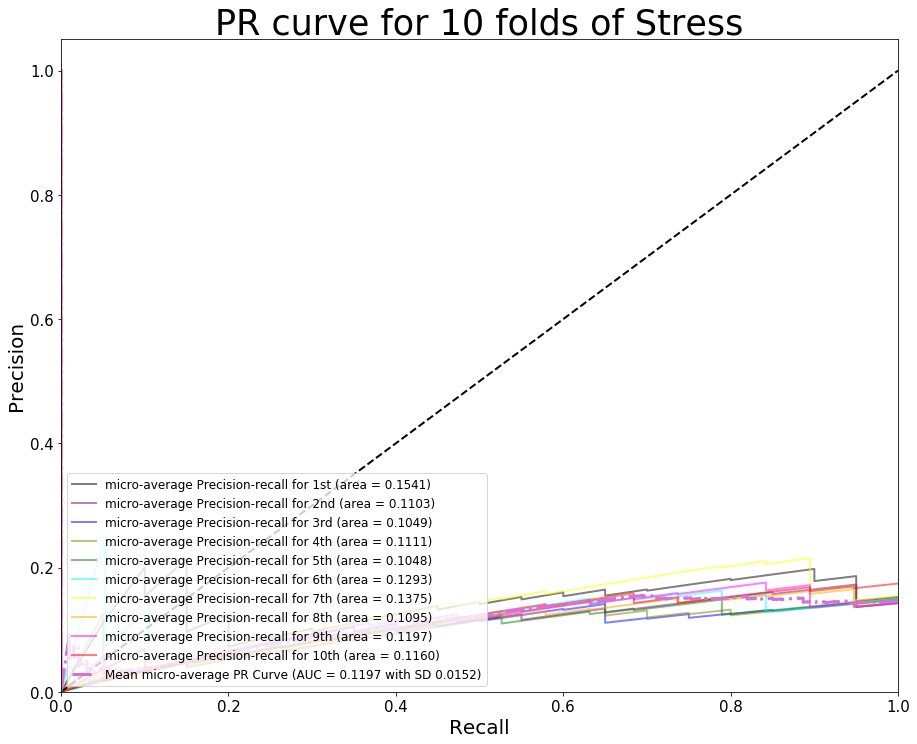

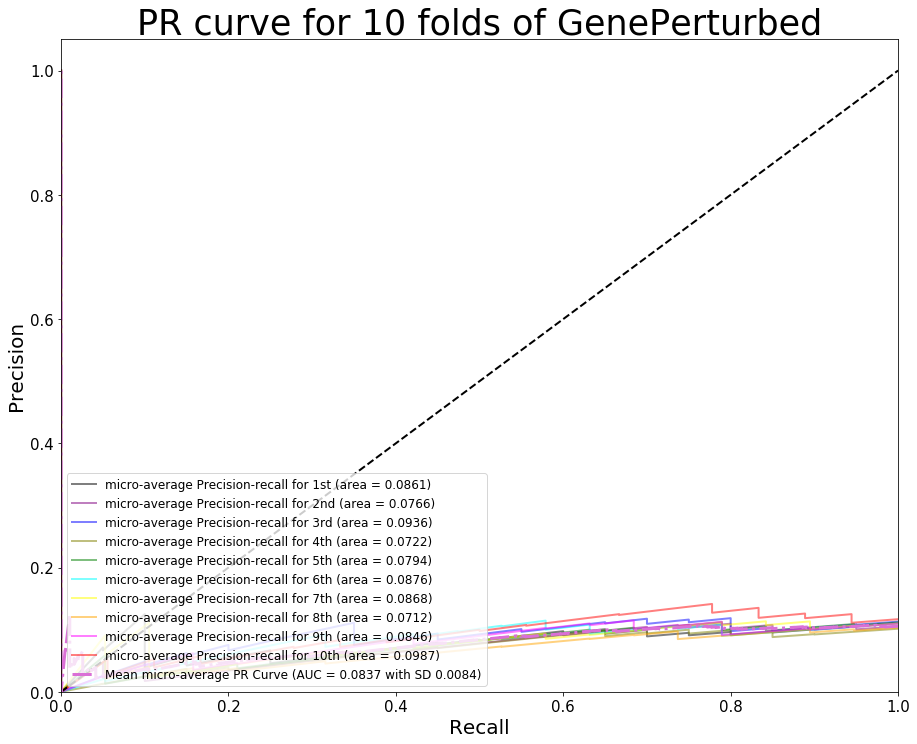

In [82]:
for i in [1,2,3,4]:
    y = meta.iloc[:,i]
    name = 'PCA_PR_'+meta.columns[i]+'.png'
    svm_cv_3(X_pca,y,name,'PR',10)